## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from pprint import pprint
import pickle
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sumedha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sumedha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints.json') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [5]:
df.shape

(78313, 22)

In [6]:
#print the column names
list_col_name=list(df.columns)
list_col_name

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [8]:
#Assign new column names
#remove _from column name 
df.columns=[re.sub('^_','',col) for col in df.columns]
#remove source. from column name
df.columns=[re.sub(r"^\bsource\b\.",'',col) for col in df.columns]

In [9]:
#column name changed confirmation
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [10]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("",np.nan,inplace=True)

In [11]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(txt):
    
    
    #Make the text lowercase
    txt=txt.lower()
    
    #Remove text in square brackets
    txt=re.sub(r'\[.*?\]','',txt)
    
    #Remove punctuation
    txt=re.sub(r'[%s]%re.escape(string.punctuation)','',txt)
    
    #Remove words containing numbers
    txt=re.sub(r'\w*\d\w*','',txt)
    
    return txt


In [13]:
df['complaint_what_happened']=df['complaint_what_happened'].astype(str)

In [14]:
df_clean=pd.DataFrame(df['complaint_what_happened'].apply(clean_text))

In [15]:
df_clean

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...
10,"chase card was reported on xx/xx/. however, fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...
...,...
78303,after being a chase card customer for well ove...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx..."
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs. i've had ...


In [16]:
#Write your function to Lemmatize the texts
def lemmatize_text(txt):
    #create empty list
    list_lemma=[]
    
    #Extract lemmas of given text and add to list
    doc=nlp(txt)
    
    for w in doc:
        list_lemma.append(w.lemma_)
    
    return " ".join (list_lemma)

In [17]:
# create column complaint_lemmatized
#df["complaint_lemmatized"] =  df.apply(lambda x: lemmatize_text(x['complaint_what_happened']), axis=1)

df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lemmatize_text)

# View the dataframe
df_clean.head()

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...


In [18]:
df_clean

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call cha , my ..."
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yr . I 've h...


In [19]:
#Write your function to extract the POS tags 
    
def pos_tag(text):
    
    #create textblob_object
    txt_blob=TextBlob(text)
    
    # extracting words with tags 'NN', joining them and return
    return ' '.join([ word for (word,tag) in txt_blob.tags if tag == "NN"])
    
    

df_clean["complaint_POS_removed"] =df_clean['complaint_lemmatized'].apply(pos_tag)#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [20]:
df_clean["complaint_POS_removed"]

1        morning name stop bank cardmember service ask ...
2        card agent upgrade date agent information orde...
10       card application identity consent service cred...
11       try book xxxx ticket offer ticket card informa...
14       son chase account fund bank account pay money ...
                               ...                        
78303    card customer decade solicitation credit card ...
78309    wednesday cha visa credit card provider claim ...
78310    pay risk provide consumer bank app chase year ...
78311    credit yr credit card chase freedom xxxx probl...
78312    year account jp bank xxxx order line credit ac...
Name: complaint_POS_removed, Length: 21072, dtype: object

In [21]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call cha , my ...",wednesday cha visa credit card provider claim ...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yr . I 've h...,credit yr credit card chase freedom xxxx probl...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [22]:
# Write your code here to visualise the data according to the 'Complaint' character length

char_len = [len(x) for x in df_clean ['complaint_POS_removed']]

char_len[:5]

[159, 101, 67, 414, 155]

Text(0, 0.5, 'Number of complaints')

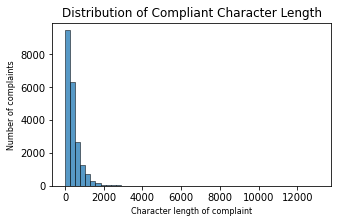

In [23]:
plt.figure(figsize=[5,3])
sns.histplot(data=char_len,bins=50)
plt.title('Distribution of Compliant Character Length')
plt.xlabel("Character length of complaint",size=8)
plt.ylabel('Number of complaints',size=8)

#### Find the top 40 words by frequency among all the articles after processing the text.

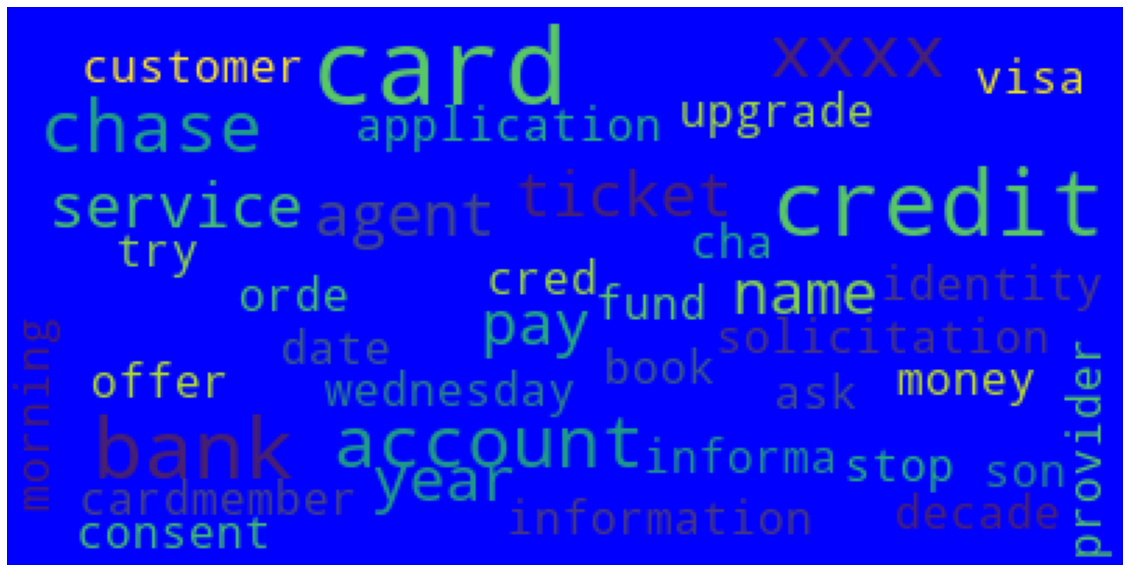

In [24]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stop_words=set(STOPWORDS)
word_cloud =WordCloud(background_color='blue',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [25]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [26]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_unigram(text, n=30):    
    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [27]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,chase,48952
1,account,47902
2,xxxx,43139
3,credit,34289
4,card,29635
5,bank,28495
6,payment,21336
7,time,16288
8,charge,15150
9,day,13060


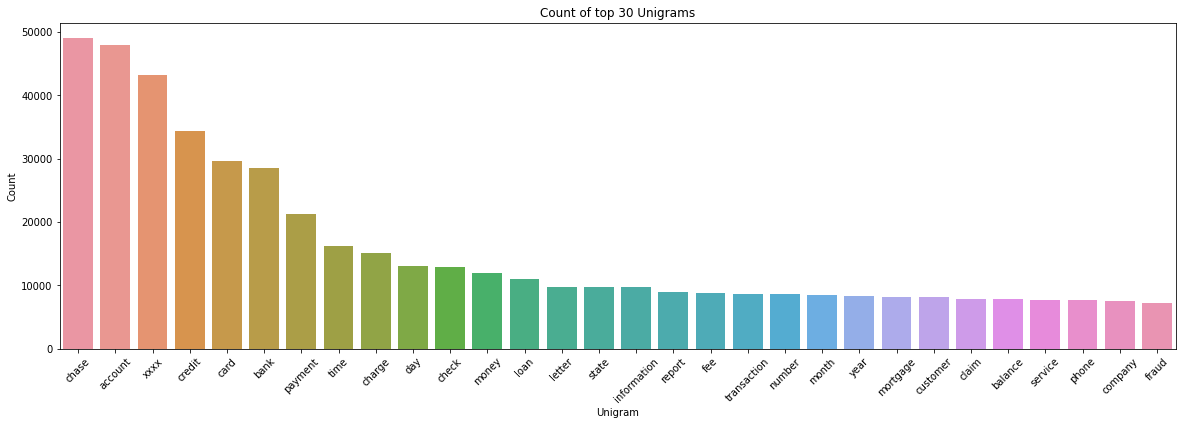

In [120]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [28]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [29]:
#Print the top 10 words in the bigram frequency
top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,12878
1,xxxx xxxx,6198
2,credit report,3952
3,customer service,3082
4,chase credit,3061
5,chase bank,2905
6,check account,2884
7,bank account,2763
8,account chase,2737
9,chase account,2441


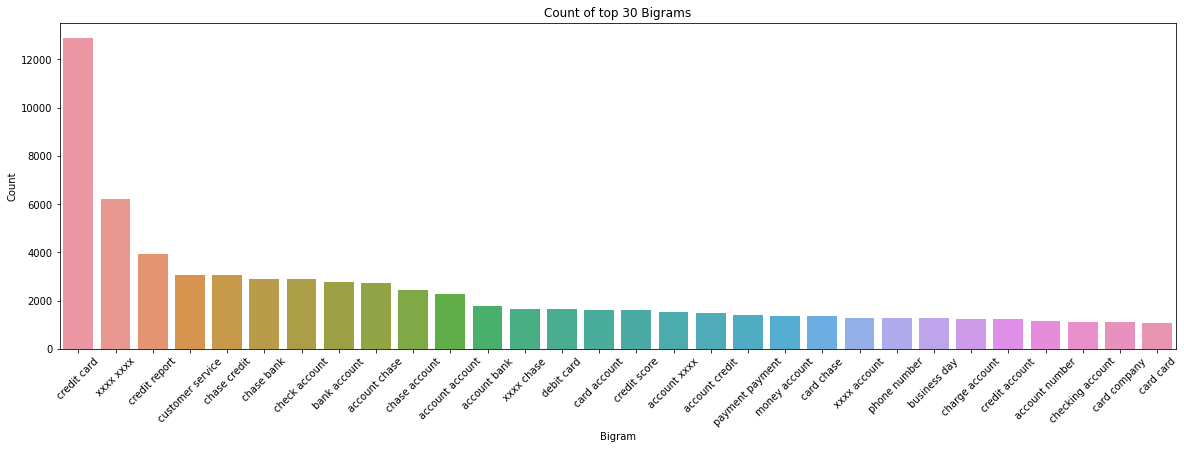

In [121]:
# Plotting top 30 Bigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram['bigram'], y=df_bigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 30 Bigrams")
plt.show()

In [30]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [31]:
#Print the top 10 words in the trigram frequency
top_common_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,chase credit card,2137
1,xxxx xxxx xxxx,1061
2,credit card account,1051
3,credit card company,995
4,credit card chase,670
5,credit card credit,509
6,inquiry credit report,482
7,charge credit card,430
8,account credit card,411
9,card credit card,382


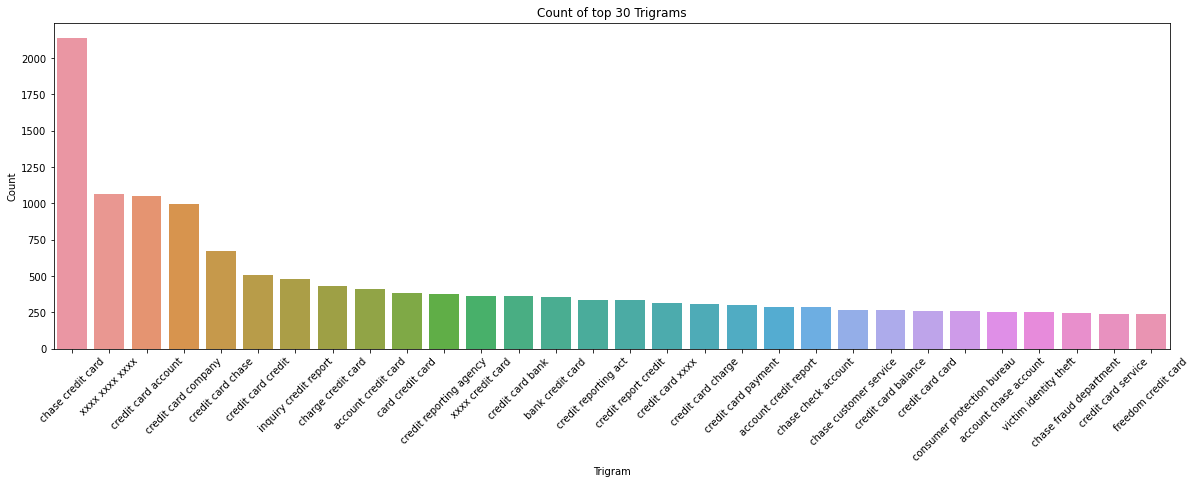

In [122]:
plt.figure(figsize=[20,6])
sns.barplot(x=df_trigram['trigram'], y=df_trigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Count of top 30 Trigrams")
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [32]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [33]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call cha , my ...",wednesday cha visa credit card provider claim ...,wednesday cha visa credit card provider claim ...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yr . I 've h...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [34]:
#Write your code here to initialise the TfidfVectorizer 

tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [35]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [36]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [37]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)  #write your code here

In [38]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

7117

In [39]:
H = nmf_model.components_ 

In [40]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,xxxx,branch,day,business,number,transaction,transfer,customer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,balance,letter,year
Topic 3,loan,mortgage,xxxx,home,chase,modification,property,year,letter,rate,document,time,bank,house,foreclosure
Topic 4,charge,card,xxxx,chase,transaction,dispute,fee,merchant,fraud,claim,purchase,service,refund,time,statement
Topic 5,payment,balance,month,fee,statement,auto,day,time,pay,date,account,credit,chase,year,mortgage


In [41]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)


In [42]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)#write your code to assign topics to each rows.

In [43]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,3
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [44]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xx...,mishandle account auto xxxx,mishandle account auto,0
17,with out notice j.p. morgan chase restricted m...,with out notice j.p . morgan chase restrict my...,j.p restrict account debit card tuesday branch...,j.p restrict account debit card tuesday branch...,0
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1
26,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...,time attempt inquiry creditor place inquiry re...,time attempt inquiry creditor place inquiry re...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [45]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others",
               3:"Theft/Dispute reporting", 4:"Mortgages/loans" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [46]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank account services
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Theft/Dispute reporting
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,Credit card / Prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card / Prepaid card
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card / Prepaid card
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call cha , my ...",wednesday cha visa credit card provider claim ...,wednesday cha visa credit card provider claim ...,Theft/Dispute reporting
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute reporting
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yr . I 've h...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...,Mortgages/loans


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [47]:
#Create the dictionary again of Topic names and Topics

Topic_names ={ "Bank account services":0, "Credit card / Prepaid card":1, "Others":2,
               "Theft/Dispute reporting":3, "Mortgages/loans":4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [48]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,3
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call cha , my ...",wednesday cha visa credit card provider claim ...,wednesday cha visa credit card provider claim ...,3
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yr . I 've h...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...,4


In [49]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Topic']]

In [50]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,3
10,"chase card was reported on xx/xx/. however, fr...",1
11,"on xx/xx/, while trying to book a xxxx xxxx ...",1
14,my grand son give me check for {$.} i deposit ...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...",3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs. i've had ...,4


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [51]:

#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint_what_happened'])

pickle.dump(vect.vocabulary_, open("count_vector.pk1", "wb"))

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)


pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [52]:
# Write your code here to build any 3 models and evaluate them using the required metrics

vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint_what_happened'])

# Save word vector
pickle.dump(vect.vocabulary_, open("count_vector.pk1", "wb"))

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

# Save tfidf
pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))


###### Logistic regression

In [53]:
from sklearn.linear_model import LogisticRegression
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [54]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [55]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [56]:
logreg.score(X_test, y_test) 

0.912870159453303

Accuracy is 91.28%

In [57]:
# Hyperparameter tuning

logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
logreg_hpt.fit(X_train, y_train);




Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


In [58]:
#check best parameter
logreg_hpt.best_params_

{'C': 4, 'solver': 'liblinear'}

In [59]:
#Evaluating the tuned mode
logreg_hpt.score(X_test, y_test)

0.9153378891419893

With Hyperparameter tuning, Accuracy is 91.53 %

In [60]:
pickle.dump(logreg_hpt, open("logreg_model.pk1", "wb"))

In [61]:
#Model Evaluation 
logreg_model = pickle.load(open("logreg_model.pk1", "rb"))

In [62]:
y_pred = logreg_model.predict(X_test)

In [63]:
print(confusion_matrix(y_test, y_pred))

[[1185   18   15   31    4]
 [  15 1152   17   46    9]
 [  30   26  864   21    3]
 [  64   46   25 1144    9]
 [   7   12   27   21  477]]


In [64]:
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [65]:
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.91      0.95      0.93      1253
Credit card / Prepaid card       0.92      0.93      0.92      1239
                    Others       0.91      0.92      0.91       944
   Theft/Dispute reporting       0.91      0.89      0.90      1288
           Mortgages/loans       0.95      0.88      0.91       544

                  accuracy                           0.92      5268
                 macro avg       0.92      0.91      0.91      5268
              weighted avg       0.92      0.92      0.92      5268



###### Decision Tree Classifier

In [66]:
from sklearn.tree import DecisionTreeClassifier

In [67]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [68]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [69]:
dt.score(X_test, y_test)

0.7790432801822323

with Deccision Tree Classifier, Accuracy is 77.90 %

In [70]:
#Hyperparameter tuning
dt_grid = {"max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [71]:
# Setup grid hyperparameter search for LogisticRegression
dt_hpt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=dt_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
dt_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 19.1min finished


In [72]:
dt_hpt.best_params_

{'max_depth': 10, 'min_samples_leaf': 17, 'min_samples_split': 2}

In [73]:
# Evaluating the tuned model
dt_hpt.score(X_test, y_test)

0.7642369020501139

With Hyperparameter tuning, Accuracy is 76.42%

In [74]:
pickle.dump(dt_hpt, open("dt_model.pk1", "wb"))

In [75]:
#Model evaluation
# Load pickled model
dt_model = pickle.load(open("dt_model.pk1", "rb"))

In [76]:
y_pred = dt_model.predict(X_test)

In [77]:
print(confusion_matrix(y_test, y_pred))

[[1015   43  110   63   22]
 [  45 1016   61   96   21]
 [  50   34  807   32   21]
 [ 174  124  175  791   24]
 [  38   33   36   40  397]]


In [78]:
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [79]:
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.77      0.81      0.79      1253
Credit card / Prepaid card       0.81      0.82      0.82      1239
                    Others       0.68      0.85      0.76       944
   Theft/Dispute reporting       0.77      0.61      0.68      1288
           Mortgages/loans       0.82      0.73      0.77       544

                  accuracy                           0.76      5268
                 macro avg       0.77      0.77      0.76      5268
              weighted avg       0.77      0.76      0.76      5268



###### Random Forest Classifier

In [81]:
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [82]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [104]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [105]:
# Getting the score of the base model
rf.score(X_test, y_test)

0.816628701594533

With Random Forest Classifier, Accuracy is 81.66%

In [106]:
#hyperparameter tuning
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# Setup random hyperparameter search for LogisticRegression
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.6min finished


In [107]:
rf_hpt.best_params_

{'n_estimators': 710,
 'min_samples_split': 18,
 'min_samples_leaf': 9,
 'max_depth': 10}

In [108]:
rf_hpt.score(X_test, y_test)

0.7484813971146546

With hyperparameter tuning, accuracy reduces to 74.84 %

In [110]:
rf_grid = {"n_estimators": [200, 260, 300],
           "max_depth": [7, 10, 15],
           "min_samples_split": [10, 12, 14],
           "min_samples_leaf": [6, 8, 10]}

In [111]:
# Setup grid hyperparameter search for LogisticRegression
rf_hpt = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 40.6min finished


In [112]:
rf_hpt.best_params_ 

{'max_depth': 15,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 260}

In [113]:
# Evaluating the tuned model
rf_hpt.score(X_test, y_test)

0.7534168564920274

In [114]:
# Save Random Forest Model
pickle.dump(rf_hpt, open("rf_model.pk1", "wb"))

In [115]:
#Model Evaluation
# Load pickled model
rf_model = pickle.load(open("rf_model.pk1", "rb"))

In [116]:
# Make predictions on test data
y_pred = rf_model.predict(X_test)

In [117]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1107   87    7   52    0]
 [  58 1038   10  133    0]
 [  61  111  735   37    0]
 [ 115  105    8 1060    0]
 [  92  160  121  142   29]]


In [118]:
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [119]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.77      0.88      0.82      1253
Credit card / Prepaid card       0.69      0.84      0.76      1239
                    Others       0.83      0.78      0.81       944
   Theft/Dispute reporting       0.74      0.82      0.78      1288
           Mortgages/loans       1.00      0.05      0.10       544

                  accuracy                           0.75      5268
                 macro avg       0.81      0.68      0.65      5268
              weighted avg       0.78      0.75      0.72      5268



###### Overall Result



1. Logistic Regression 

    Accuracy  91.28 %
    Precision 92 %
    Recall 92%

2. Decision Tree Classifier

    Accuracy 77.90 %
    Precision 77 %
    Recall 76 %

3. Random Forrest Classifore

   Accuracy 81.66 %
   Precision 78 %
   Recall 75 %

###### Conclusion

Based on above results, Logistic regression is best model with accuracy of  91.28%